In [1]:
import matplotlib.colors as mcolors
import matplotlib.animation as ma
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from itertools import product
import pandas as pd
import numpy as np
import numba as nb
import imageio
import sys
import os
import shutil

randomSeed = 100

%matplotlib inline
%config InlineBackend.figure_format = "svg"

new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "new", plt.cm.jet(np.linspace(0, 1, 256)) * 0.85, N=256
)

@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)

import seaborn as sns

sns.set(font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["font.family"] = "STIXGeneral"

sys.path.append("..")
from swarmalatorlib.template import Swarmalators2D

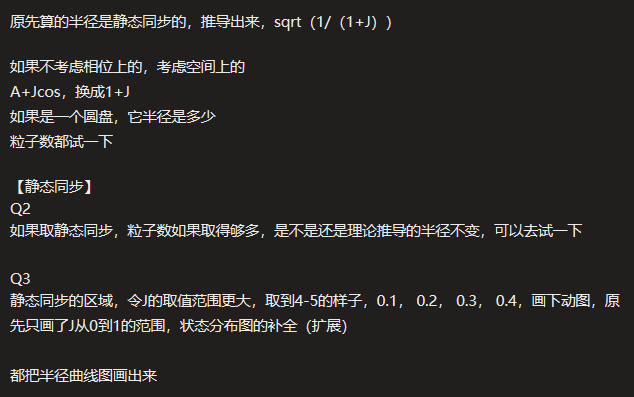

In [2]:
import numpy as np


class Strogatz2017(Swarmalators2D):
    def __init__(self, agentsNum: int, dt: float, 
                 K: float, J: float, fixSpiralPhaseCoupling: bool = False,
                 randomSeed: int = 100, tqdm: bool = False, savePath: str = None, shotsnaps: int = 5) -> None:
        super().__init__(agentsNum, dt, K, randomSeed, tqdm, savePath, shotsnaps)
        self.J = J
        self.fixSpiralPhaseCoupling = fixSpiralPhaseCoupling
        self.one = np.ones((agentsNum, agentsNum - 1))

    @property
    def Fatt(self) -> np.ndarray:
        """
        Effect of phase similarity on spatial attraction

        if fixSpiralPhaseCoupling is True, then Fatt = 1 + J

        else Fatt = 1 + J * cos(theta_j - theta_i)
        """
        return 1 + self.J * np.cos(self.deltaTheta)
    
    @property
    def Frep(self) -> np.ndarray:
        """Effect of phase similarity on spatial repulsion: 1"""
        return self.one
    
    @property
    def Iatt(self) -> np.ndarray:
        """Spatial attraction: (x_j - x_i) / |x_j - x_i|"""

        return self.deltaX / self.distance_x_2(self.deltaX)
    
    @property
    def Irep(self) -> np.ndarray:
        """Spatial repulsion: (x_j - x_i) / |x_j - x_i| ^ 2"""
        return self.deltaX / self.distance_x_2(self.deltaX) ** 2
    
    @property
    def H(self) -> np.ndarray:
        """Phase interaction: sin(theta_j - theta_i)"""
        return np.sin(self.deltaTheta)
    
    @property
    def G(self) -> np.ndarray:
        """Effect of spatial similarity on phase couplings: 1 / |x_i - x_j|"""
        return 1 / self.distance_x(self.deltaX)
    
    @property
    def velocity(self) -> np.ndarray:
        """Self propulsion velocity: 0"""
        return 0
    
    @property
    def omega(self) -> np.ndarray:
        """Natural frequency: 0"""
        return 0
    
    def __str__(self) -> str:
        if self.fixSpiralPhaseCoupling:
            return f"Strogatz2017_{self.agentsNum}_{self.K}_{self.J}_fix"
        else:
            return f"Strogatz2017_{self.agentsNum}_{self.K}_{self.J}"

In [9]:
model = Strogatz2017(agentsNum=1000, dt=0.1, K=1, J=0.5, 
                     fixSpiralPhaseCoupling=True, randomSeed=randomSeed, 
                     tqdm=True, savePath="data", shotsnaps=1)

In [10]:
model.run(1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1001 [00:00<?, ?it/s]

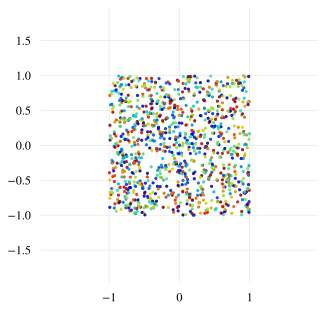

In [11]:
targetPath = f"./data/{model}.h5"

totalPositionX = pd.read_hdf(targetPath, key="positionX")
totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")

TNum = totalPositionX.shape[0] // model.agentsNum

totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2)
totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, model.agentsNum)

positionLim = np.max(np.abs(totalPositionX)) * 1.1

# TNum = 100
pbar = tqdm(total=TNum)

def plot_frame(i):
    if model.tqdm:
        pbar.update(1)
    positionX = totalPositionX[i]
    phaseTheta = totalPhaseTheta[i]

    # fig.clear()
    ax.clear()
    ax.scatter(positionX[:, 0], positionX[:, 1], s=5, c=phaseTheta, cmap=new_cmap, vmin=0, vmax=2 * np.pi, alpha=0.8)
    ax.set_xlim(-positionLim, positionLim)
    ax.set_ylim(-positionLim, positionLim)

fig, ax = plt.subplots(figsize=(5, 5))
ani = ma.FuncAnimation(fig, plot_frame, frames=np.arange(0, TNum), interval=50, repeat=False)
ani.save(f"{model}.mp4", dpi=200)